[![Open In Colab](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/badge/open-in-colab.svg)](https://colab.research.google.com/github/crunchdao/quickstarters/blob/feat/synth/competitions/synth/quickstarters/baseline/baseline.ipynb)

![Banner](https://raw.githubusercontent.com/crunchdao/quickstarters/refs/heads/feat/synth/documentation/assets/generic/banner.webp)

# Introduction

Synth (Subnet 50) redefines how synthetic financial data is modelled and utilized for predictive intelligence.

Powered by Bittensor’s decentralized intelligence network, Synth replaces the traditional, opaque data models with an open, verifiable, and continuously evolving synthetic data layer where the models compete, refine, and enhance monte-carlo simulations of price forecasts to unprecedented levels.

- [Visit their website](https://www.synthdata.co/)
- [Read more in the whitepaper](https://mode-network.github.io/synth-subnet/Synth%20Whitepaper%20v1.pdf)

# Setup

The first steps to get started are:
1. Install the [package dedicated to this competition](https://github.com/crunchdao/synth-crunch)

In [ ]:
%pip install synth-crunch

# Your model

## Setup

In [11]:
from typing import Any
from datetime import datetime

# Import the synth classes
from synth_crunch import SynthMiner, Asset

## Implementation

### `SynthMiner.generate_simulations()`

You must implement a class with the mandatory function, generate_simulations().

This function will be called each time the protocol asks your model to make predictions.

You must predict the possible paths (called simulations), of an `asset` at regular intervals (`time_increment`), for a determined amount of time (`time_length`).

In [12]:
from synth_crunch.baseline import simulate_crypto_price_paths, convert_prices_to_time_format


class MyMiner(SynthMiner):

    def __init__(self):
        # Initialize your state in the constructor:
        # - load your model
        # - warmup your code

        pass

    def generate_simulations(
        self,
        asset: Asset,  # can only be "BTC", "ETH", "XAU" or "SOL"
        current_price: float,
        start_time: str,
        time_increment: int,
        time_length: int,
        num_simulations: int,
        sigma: float,
    ) -> list[list[dict[str, Any]]]:
        """
        Generate simulated price paths.

        Parameters:
            asset (str): The asset to simulate.
            current_price (float): The current price of the asset to simulate.
            start_time (str): The start time of the simulation. Defaults to current time.
            time_increment (int): Time increment in seconds.
            time_length (int): Total time length in seconds.
            num_simulations (int): Number of simulation runs.
            sigma (float): Standard deviation of the simulated price path.

        Returns:
            numpy.ndarray: Simulated price paths.
        """

        if start_time == "":
            raise ValueError("Start time must be provided.")

        if asset == "BTC":
            sigma *= 3
        elif asset == "ETH":
            sigma *= 1.25
        elif asset == "XAU":
            sigma *= 0.5
        elif asset == "SOL":
            sigma *= 0.75

        simulations = simulate_crypto_price_paths(
            current_price=current_price,
            time_increment=time_increment,
            time_length=time_length,
            num_simulations=num_simulations,
            sigma=sigma,
        )

        predictions = convert_prices_to_time_format(
            prices=simulations.tolist(),
            start_time=start_time,
            time_increment=time_increment,
        )

        return predictions

## Local testing

### Using historical data

We recommend using historical data for quick iterations because you can be scored immediately.

Once you have generated your simulations, they are validated to ensure that you are ready for the network.

In [13]:
# Import the function
from synth_crunch import test_historical

# Run the tester
result = test_historical(
    # You must instantiate your miner.
    MyMiner(),

    # Specify which asset you want to run with: "BTC," "ETH," "XAU," or "SOL".
    "BTC",

    # Customize the start date (default to 1st of February 2024 at 02:00 PM).
    start=datetime(2024, 2, 1, 14),

    # Customize the time increment between two predictions (default to 5min).
    time_increment=300,

    # Customize the duration of a simulation; it must be a divisor of the time increment (default to 24h).
    time_length=86400,

    # Customize the number of simulations to run (default to 300).
    num_simulations=10,
)

#### Visualize your simulations

The utility provides a quick way to visualize your simulations.

To clearly see the different paths, we suggest keeping the number of simulations low.

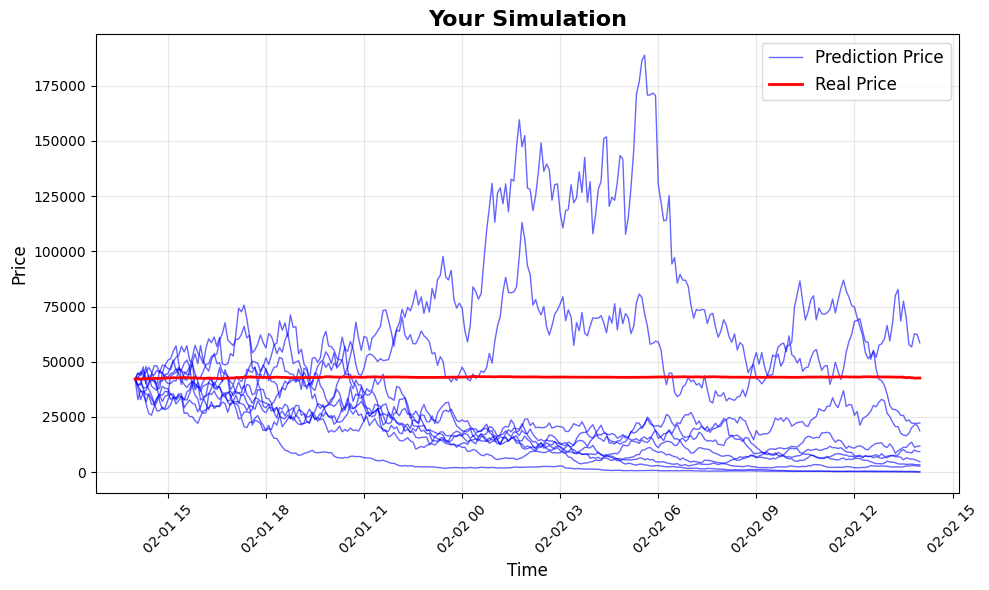

In [14]:
# Import the function
from synth_crunch import visualize_simulations

visualize_simulations(
    result,
)

#### Score your simulations

Your simulations will be scored using [Synth Subnet's scoring function](https://github.com/mode-network/synth-subnet/blob/d076dc3bcdf93256a278dfec1cbe72b0c47612f6/synth/validator/crps_calculation.py#L5).

In [15]:
# Import the function
from synth_crunch import score_simulations

# Score your results
scored_result = score_simulations(
    result,
)

print("My miner score is:", scored_result.score)
print()

print("More details:")
print(scored_result.score_summary)

My miner score is: 123045.92647427184

More details:
  Interval          CRPS
      5min  72507.535492
     30min  31122.896597
     3hour  13622.354104
24hour_abs   5793.140281
   Overall 123045.926474


### Using live data

Once you're ready, you can run your miner against live data.

However, the longer your `time_length` is, the longer you will have to wait to score your simulations.

In [16]:
# Import the function
from synth_crunch import test_live

# Run the tester
result = test_live(
    # You must instantiate your miner.
    MyMiner(),

    # Specify which asset you want to run with: "BTC," "ETH," "XAU," or "SOL".
    "BTC",

    # Customize the time increment between two predictions (default to 1min).
    time_increment=60,

    # Customize the duration of a simulation; it must be a divisor of the time increment (default to 5min).
    time_length=300,

    # Customize the number of simulations to run (default to 100).
    num_simulations=100,
)

#### Visualize your simulations

You can also visualize the different paths generated by your miner. The only difference is that there are no lines for the actual price.

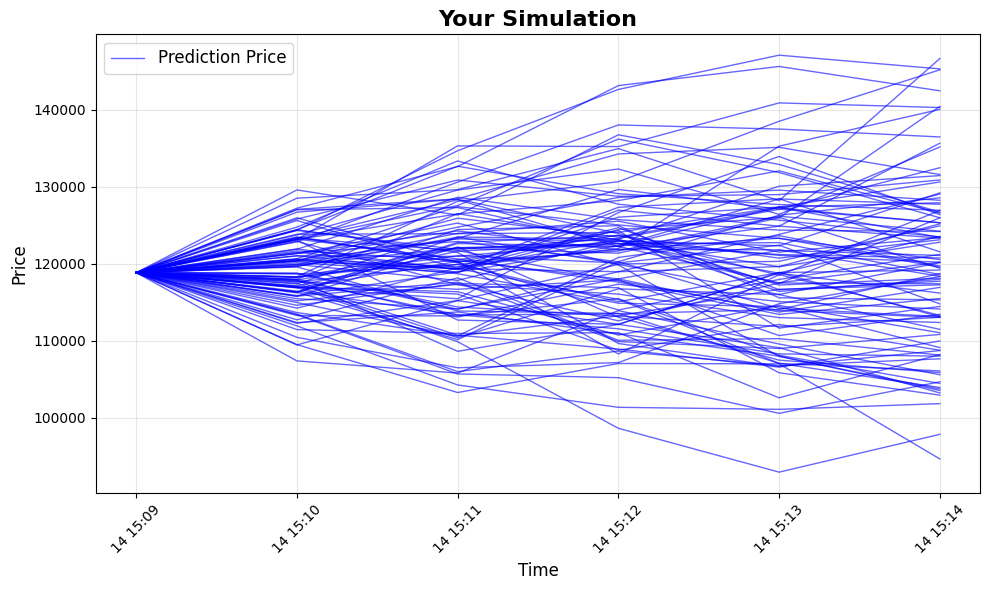

In [17]:
# Import the function
from synth_crunch import visualize_simulations

visualize_simulations(
    result,
)

In [18]:
# Import the function
from synth_crunch import score_simulations

# Score your results
scored_result = score_simulations(
    result,
)

print("My miner score is:", scored_result.score)
print()

print("More details:")
print(scored_result.score_summary)

Waiting 302.958401 seconds (include extras to be safe) until the simulations target are resolved. Do an interrupt (Ctrl+C) if you want to stop early.


Waiting for targets to resolve:   0%|          | 0/303 [00:00<?, ?s/s]

My miner score is: 424.52744584503694

More details:
  Interval       CRPS
      5min 212.064078
24hour_abs 212.463368
   Overall 424.527446


### Querying more historical data

To meet your training needs, you can query the historical data provided by [Pyth](https://www.pyth.network/).

In [25]:
# Import the function
from synth_crunch import pyth

prices = pyth.get_price_history(
    # Specify which asset you want to get data of: "BTC," "ETH," "XAU," or "SOL".
    asset="BTC",

    # Start time of the data
    from_=datetime(2024, 1, 1),

    # End time of the data
    to=datetime(2024, 1, 6),
)

prices

timestamp
2024-01-01 00:00:00+00:00    42293.659914
2024-01-01 00:01:00+00:00    42315.081222
2024-01-01 00:02:00+00:00    42322.348746
2024-01-01 00:03:00+00:00    42362.652941
2024-01-01 00:04:00+00:00    42393.662777
                                 ...     
2024-01-05 23:56:00+00:00    44157.173768
2024-01-05 23:57:00+00:00    44153.380035
2024-01-05 23:58:00+00:00    44152.707694
2024-01-05 23:59:00+00:00    44180.200800
2024-01-06 00:00:00+00:00    44164.942606
Name: price, Length: 7199, dtype: float64

# Submit your Notebook

To submit your work, you must:
1. Download your Notebook from Colab
2. Upload it to the platform
3. Create a run to validate it

### >> https://hub.crunchdao.com/competitions/synth/submit/notebook

TODO GIF with deploying a submission, not creating a run

![Download and Submit Notebook](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/animations/download-and-submit-notebook.gif)